In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import random

In [ ]:
class ES():
    def __init__(self, domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=False):
        assert population_size <= offspring_size
        if type(domain) is tuple:
            self.domain = np.array([domain] * dim)
        else:
            self.domain = np.array(domain)

        self.dim = dim
        self.mu = population_size
        self.lam = offspring_size
        lr = 0.01 #K 
        self.tau0, self.tau = lr/np.sqrt(2 * np.sqrt(self.dim)), lr/np.sqrt(2*self.dim)
        self.fitness = fitness
        self.max_iter = max_iter
        self.plus = plus
        if parent_random:
            self.parent_selection = self.parent_selection_random
        else:
            self.parent_selection = self.parent_selection_roulette

    def initial_individual(self):
        x = np.random.uniform(self.domain[:,0], self.domain[:,1], size=self.dim)
        sigma = np.random.uniform(3, 8, size=self.dim)

        return np.vstack((x, sigma))

    def random_individual(self):
        x = np.random.uniform(self.domain[:,0], self.domain[:,1], size=self.dim)
        sigma = np.random.uniform(0.5, 1.5, size=self.dim)

        return np.vstack((x, sigma))

    def generate_population(self, initial=False):
        P = []
        for _ in range(self.mu):
            if initial:
                P.append(self.initial_individual())
            else:
                P.append(self.random_individual())
        P = np.array(P)
        return np.array(P)

    # def mutate(self, P):
    #     xs, sigmas = P[:, 0], P[:, 1]
    #     mutated = []
    #     for i in range(len(P)):
    #         eps0 = np.random.normal(0, self.tau0)
    #         eps = np.random.normal(0, self.tau, size=self.dim)
            
    #         new_sigma = sigmas[i] * np.exp(eps0 + eps)

    #         new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
    #         its = 0
    #         while (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])) and its < 4:
    #             its += 1
    #             new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
    #         if (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])):
    #             new_x, new_sigma = self.random_individual()
            
    #         mutated.append(np.vstack((new_x, new_sigma)))
    #     return np.array(mutated)

    def mutate(self, P):
        xs, sigmas = P[:, 0], P[:, 1]
        assert type(sigmas) == np.ndarray
        mutated = []

        for i in range(len(P)):
            eps0 = np.random.normal(0, self.tau0**2)
            eps = np.random.normal(0, self.tau**2)
            multiplier = np.exp(eps0 + eps)
            
            new_sigma = sigmas[i] * multiplier

            new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
            its = 0
            while (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])) and its < 4:
                its += 1
                new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
            if (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])):
                new_x, new_sigma = self.random_individual()
            
            mutated.append(np.vstack((new_x, new_sigma)))
            
        return np.array(mutated)

    def replacement(self, P, P_costs, pc, pc_costs):
        if(self.plus):
            combined = np.concatenate((P, pc), axis=0)
            assert combined.shape == (self.mu + self.lam, 2, self.dim), f"{combined.shape}"
            combined_scores = np.concatenate((P_costs, pc_costs))
            indices = np.argsort(combined_scores)
            assert combined_scores[indices[0]] <= combined_scores[indices[-1]]
            P = combined[indices[:self.mu]]
        else:
            scores = np.array([self.fitness(p[0]) for p in pc])
            indices = np.argsort(scores)
            P = pc[indices[:self.mu]]
        return P

    def parent_selection_random(self, P, score):
        return P[np.random.choice(len(P), self.lam, replace=True)]

    def parent_selection_roulette(self, P, score):
        if np.min(score) == np.max(score):
            idxs = np.random.choice(len(P), size=self.lam, replace=True)
        else:
            std_costs = (score - np.min(score)) / (score - np.min(score)).max()
            p_costs = (1 - std_costs)
            idxs = np.random.choice(len(P), p=p_costs / sum(p_costs), size=self.lam, replace=True)
        return P[idxs].copy()

    def run(self):
        P = self.generate_population(initial=True)
        assert P.shape == (self.mu, 2, self.dim) 
        score = np.array([self.fitness(p[0]) for p in P])
        best_score = np.min(score)
        best_sigma = []
        best_individual = P[np.argmin(score)]

        iter_min, iter_mean, iter_max = [], [], []
        range_ = trange(int(self.max_iter), position=0, leave=True)
        try:
            for _iter in range_:
                parents = self.parent_selection(P, score)
                assert parents.shape == (self.lam, 2, self.dim)

                mutation = self.mutate(parents)
                assert mutation.shape == (self.lam, 2, self.dim)

                P = self.replacement(P, score, mutation, [self.fitness(p[0]) for p in mutation])
                assert P.shape == (self.mu, 2, self.dim), f'{P.shape}'

                score = np.array([self.fitness(p[0]) for p in P])

                min_score_index = np.argmin(score)
                min_score = np.min(score)
                if min_score < best_score:
                    best_score = min_score
                    best_individual = P[min_score_index]
                
                # print(f'Iter: {_iter}, best: {best_score}')
                iter_min.append(np.min(score))
                iter_mean.append(np.mean(score))
                iter_max.append(np.max(score))
                #calculate mean of P[1]:
                best_sigma.append(np.mean(P[:, 1]))
        except KeyboardInterrupt:
            pass

        return best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max


In [3]:
def showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima):
    print(f'Best individual: {best_individual[0]}')
    print(f'Best score: {best_score}')
    plt.plot(iter_mean, label='mean')
    plt.plot(iter_min, label='min')
    global_minima_array = np.full(len(iter_min), global_minima)
    plt.plot(global_minima_array, label='min_global', color='r')
    plt.legend()
    plt.title(problem_name)
    plt.show()

    plt.plot(best_sigma, label='sigma')
    plt.title('Sigma')
    plt.show()

def ESPlusRandom(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=True, parent_random=True)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESPlusRoulette(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=True, parent_random=False)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESCommaRandom(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=True)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESCommaRoulette(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=False)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

In [33]:
#benchmark 1 Sphere function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1113.htm
def Sphere(individual): 
    d = len(individual)
    return np.sum(individual**2)

domain = (-5.12, 5.12)
dims = 50
initial_population = 4000
offspring_size = 21000
iterations = 300

#wektor sigm dodac -> losowo, rosly, spadac

100%|██████████| 300/300 [02:43<00:00,  1.83it/s]

Best individual: [ 0.00825767 -0.02262522 -0.02461492 -0.01317133 -0.00540687  0.00248752
 -0.00988629  0.02850787  0.01054607  0.00280068  0.03024782 -0.03035546
  0.02507688 -0.02472927  0.00808664  0.01359702 -0.02313634 -0.00597625
  0.01100115 -0.00551755  0.02357678  0.02296126  0.0071839  -0.0027528
 -0.026098    0.0080721  -0.01363457 -0.00206954  0.00371905  0.02078955
  0.00539732  0.01610409  0.00858731 -0.01100786  0.0239208  -0.01681237
 -0.03002644 -0.02179083 -0.01034264  0.01219461  0.00332418 -0.02845067
  0.01326823 -0.00819997 -0.01799186  0.0013011  -0.01894071  0.01427644
 -0.00330093  0.00765021]
Best score: 0.013990184329842862


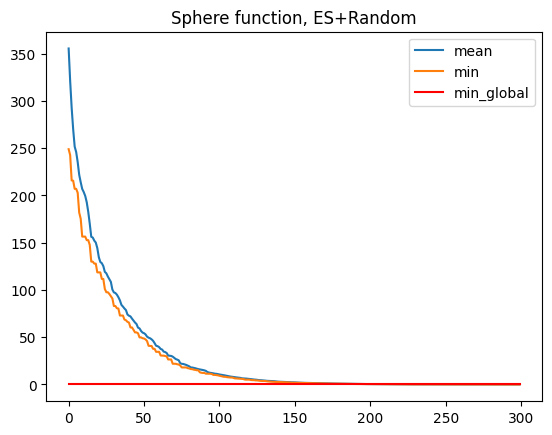

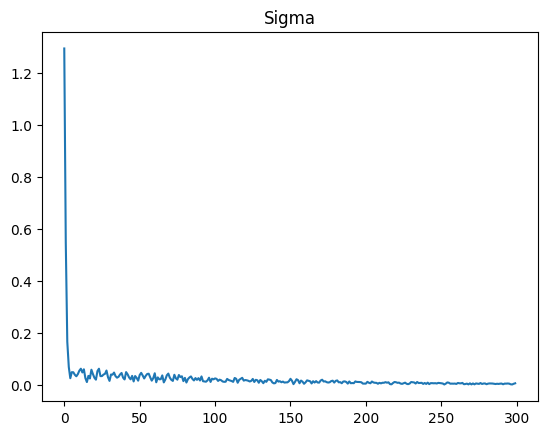

In [23]:
ESPlusRandom(domain, dims, initial_population, offspring_size, Sphere, iterations, 'Sphere function, ES+Random', 0)

100%|██████████| 300/300 [02:41<00:00,  1.86it/s]

Best individual: [ 1.33731277e-04  7.70509091e-05  1.05420718e-04  7.17351919e-07
 -6.58926950e-05  3.28832195e-05  8.71526912e-05 -4.33586948e-05
 -3.34202655e-05 -1.09587513e-04  3.96526683e-05 -2.60701789e-05
 -1.87220895e-05  5.56903722e-05  2.58516322e-05 -2.19991238e-05
  4.57297586e-05 -6.85797324e-05 -8.99511326e-05 -3.90879366e-05
 -5.03343087e-05  1.41337446e-05  2.27141410e-05 -7.12048180e-05
  8.41023865e-05 -1.18462386e-05  1.30278603e-05 -5.08619769e-05
 -1.62258272e-04  2.09639869e-06 -5.91256076e-05  4.53967347e-05
 -1.16696753e-04  1.09725191e-04 -6.10760482e-05 -2.27170170e-05
  5.19779936e-05 -3.25758552e-06 -9.90129473e-05 -1.59662279e-05
 -9.98529161e-05  2.03609207e-05  5.93203165e-05 -4.33679946e-06
 -8.20539142e-05 -8.42973490e-06 -5.79516840e-06  6.51090256e-05
  3.53579173e-05 -5.85725392e-05]
Best score: 2.0876345180624346e-07


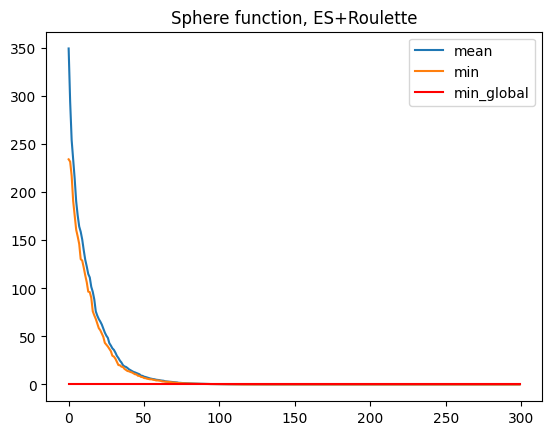

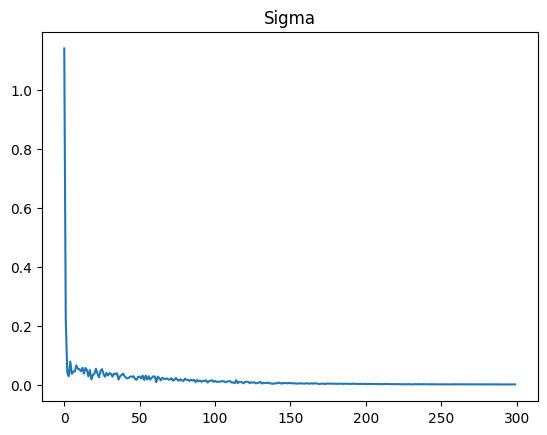

In [29]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, Sphere, iterations, 'Sphere function, ES+Roulette', 0)

100%|██████████| 300/300 [03:19<00:00,  1.50it/s]

Best individual: [-0.00560216 -0.04874627 -0.02826328  0.05945319  0.01209096  0.00200347
 -0.01926566  0.02673783  0.02230349 -0.03043596  0.02926757 -0.0051356
 -0.01219353 -0.0247535  -0.03549334 -0.00586825  0.04332204  0.01227671
  0.01004734 -0.02145229 -0.01520092  0.01051655  0.01459348 -0.05174474
  0.04624529 -0.02895141  0.02353381 -0.01596842  0.04632676 -0.04020528
  0.04293867 -0.00376147 -0.01130865 -0.00925359  0.02375784 -0.01560705
 -0.00043002  0.01157532 -0.00101518  0.01908819  0.00748345  0.01921166
 -0.00038002  0.02044622 -0.02938693 -0.04341747  0.0338558   0.0273825
  0.04420648 -0.00658506]
Best score: 0.036573358754117026


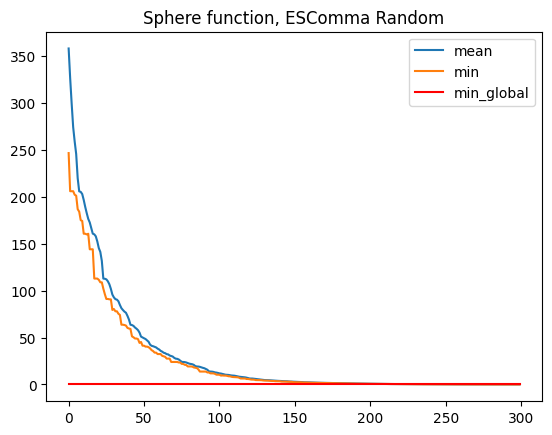

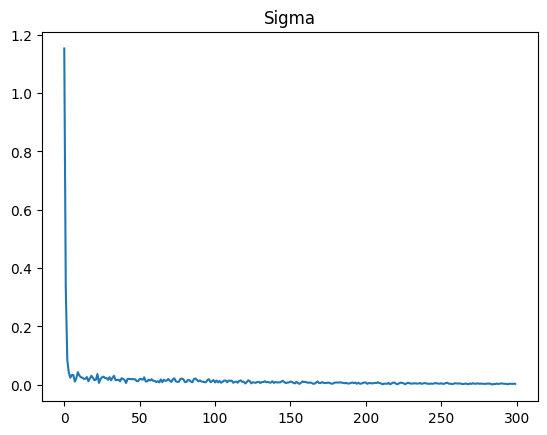

In [30]:
ESCommaRandom(domain, dims, initial_population, offspring_size, Sphere, iterations, 'Sphere function, ESComma Random', 0)

100%|██████████| 300/300 [02:54<00:00,  1.72it/s]

Best individual: [-4.00774813e-05 -1.36942055e-04  1.54051219e-05  1.40179272e-04
  3.08409948e-05  1.30145465e-05  4.60796027e-05 -2.27950104e-05
 -1.05137311e-04 -4.82805588e-05 -4.88691207e-05 -6.86997811e-06
  9.32633080e-05  6.87078353e-05  1.49572875e-04  5.45287380e-06
 -9.72136386e-05  1.28099275e-05 -2.12819725e-05 -1.23539907e-04
 -8.76194478e-05  6.87830921e-05  6.40687686e-05 -9.43526691e-05
  7.10707645e-05 -4.15886612e-05 -1.18323481e-04  2.60843131e-05
  9.68610281e-05 -1.67292199e-04  2.10652128e-06  1.63692606e-04
  6.72821605e-05 -9.11355608e-05  9.18107236e-05 -9.54515397e-05
  1.34477523e-04  7.36207342e-05  6.25391106e-05 -3.43622824e-05
  4.48192621e-05  6.76637508e-05 -6.41076482e-05 -7.82467234e-05
 -1.32525778e-04  3.10933909e-05 -1.33560702e-04  1.06775179e-04
 -5.94212989e-05  6.49841719e-05]
Best score: 3.6333780560941903e-07


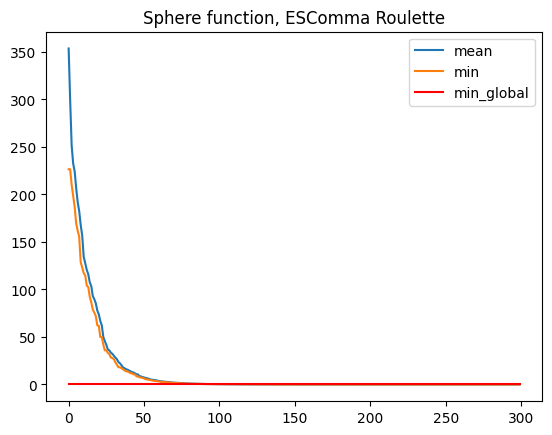

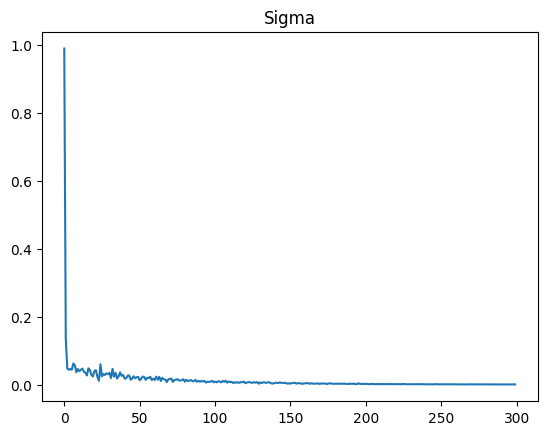

In [34]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, Sphere, iterations, 'Sphere function, ESComma Roulette', 0)

In [6]:
#benchmark 2 Rastrigin function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page2607.htm
def Rastrigin(individual):
    d = len(individual)
    return 10*d + np.sum(individual**2 - 10*np.cos(2*np.pi*individual))

domain = (-5.12, 5.12)
dims = 10
initial_population = 1000
offspring_size = 4000
iterations = 230

 54%|█████▍    | 124/230 [00:11<00:09, 10.85it/s]

Best individual: [-7.39686063e-05 -1.11941548e-04  1.98993490e+00  1.58723534e-05
 -9.95175853e-01 -5.38874598e-05 -9.94689998e-01  9.94790322e-01
 -9.94639515e-01  1.98978247e+00]
Best score: 11.939555720086574


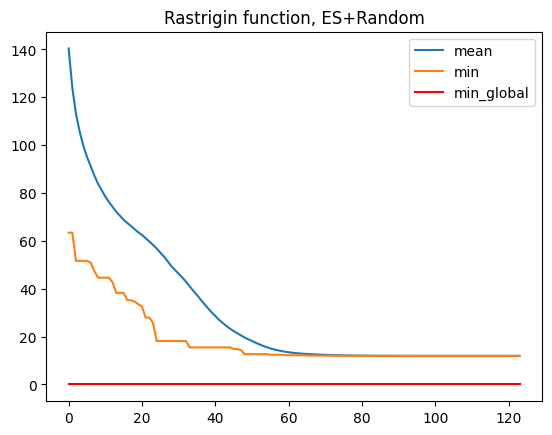

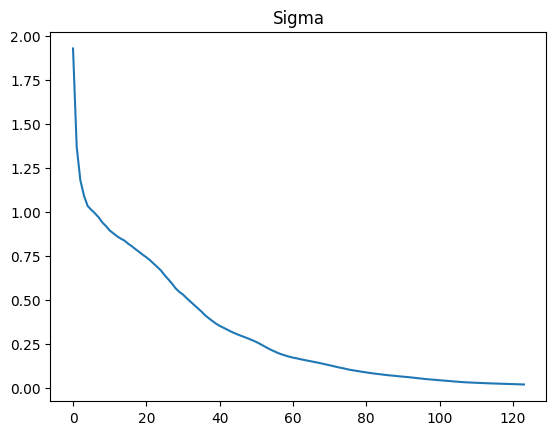

In [9]:
ESPlusRandom(domain, dims, initial_population, offspring_size, Rastrigin, iterations, 'Rastrigin function, ES+Random', 0) #sigma start = 2, K = 10

 66%|██████▌   | 328/500 [02:55<01:32,  1.86it/s]

Best individual: [ 2.98491416e+00 -9.94891065e-01  9.95057415e-01  9.94970258e-01
 -1.98996315e+00  4.21941484e-04 -1.98990906e+00  9.94940453e-01
 -1.99006238e+00 -9.94808251e-01 -1.99003269e+00 -9.94904429e-01
 -1.98975130e+00 -1.99002762e+00 -9.94791584e-01 -9.95206700e-01
 -9.95108440e-01 -9.93043610e-01 -2.98502094e+00 -1.98984998e+00
 -9.95153021e-01 -9.94672287e-01 -9.94912839e-01 -1.98990534e+00
  9.95326594e-01 -1.98986716e+00  9.95009248e-01 -2.41094327e-05
  1.98985787e+00 -1.98993615e+00  9.94774837e-01  9.94960415e-01
  1.98997624e+00 -1.98978504e+00 -9.94936501e-01  1.09461486e-04
 -1.99000354e+00  9.94837775e-01  2.98495806e+00 -1.98990038e+00
  3.13748011e-04  1.98949127e+00  3.52576723e-05  8.88549384e-05
 -4.97467075e+00  9.94963516e-01 -1.98991037e+00 -9.94919207e-01
  2.04717575e-04 -9.95181575e-01 -1.98988188e+00  3.97977003e+00
 -2.98588082e+00  1.98981089e+00  1.98981285e+00 -2.98487467e+00
  9.94946682e-01  9.95258626e-01  2.98514471e+00 -1.98984604e+00]
Best sc

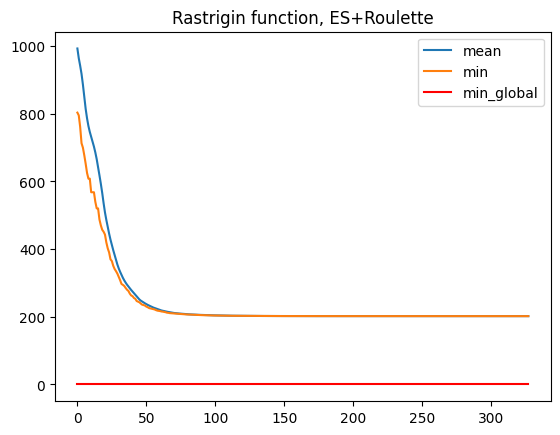

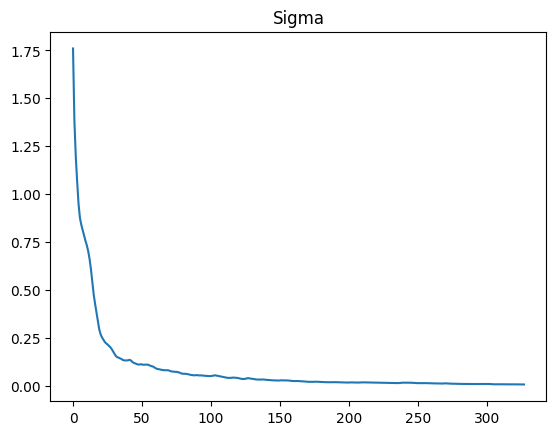

In [42]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, Rastrigin, iterations, 'Rastrigin function, ES+Roulette', 0)

100%|██████████| 230/230 [02:20<00:00,  1.64it/s]

Best individual: [-1.95912878e+00 -1.00320503e+00  1.02982036e+00  8.86592294e-03
  1.97687121e+00 -1.03154587e-02  1.99152538e+00  1.98255906e+00
  2.13724117e-03  2.05410354e+00  1.99084864e+00  1.63552035e-03
  1.97389399e+00  1.98400710e+00 -1.98072672e+00 -9.92661229e-01
 -2.98306873e+00 -4.10250717e-03 -1.98445582e+00  9.52251222e-01
 -1.98625976e+00  9.95992512e-01  1.66579862e-02 -9.94792208e-01
 -2.98316577e+00 -2.51589385e-03 -4.01902138e+00 -1.99671242e+00
  9.96160331e-01 -2.98842890e+00  9.86909147e-01 -2.97978928e+00
  1.00810602e+00 -9.97979035e-01  2.98562121e+00 -8.95112790e-03
  2.97902074e+00 -9.93477655e-01  3.98366339e+00 -2.48665885e-04
 -1.97507898e+00  1.00406448e+00  1.00355223e+00 -3.98716015e+00
  1.99443136e+00  2.98527110e+00 -9.94358773e-01 -1.98572916e+00
 -1.98945735e+00  1.02789633e-02 -3.11175017e-03  2.01053960e+00
  7.58588450e-03  2.98245737e+00 -1.75848400e-03 -2.97562482e+00
  1.18713798e-03 -1.99767410e+00 -4.58732311e-03 -3.38654611e-03]
Best sc

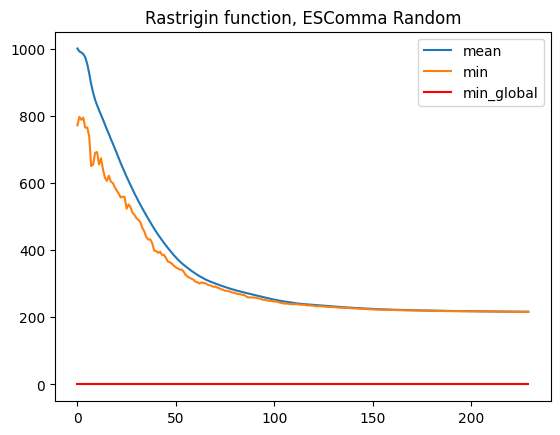

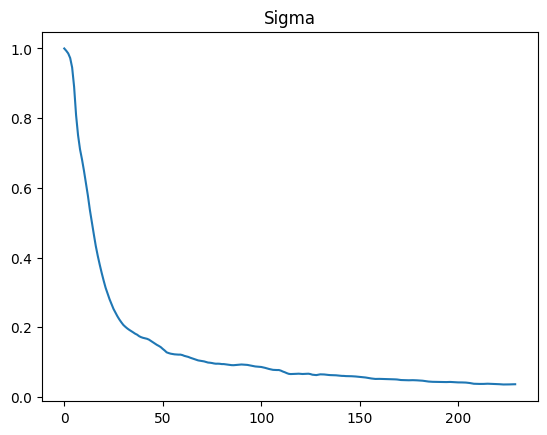

In [60]:
ESCommaRandom(domain, dims, initial_population, offspring_size, Rastrigin, iterations, 'Rastrigin function, ESComma Random', 0)

100%|██████████| 230/230 [02:20<00:00,  1.64it/s]

Best individual: [-1.63910439e-02 -1.99498665e+00  9.96507202e-03 -5.47485928e-03
  1.97288259e+00 -1.99094628e+00 -1.98827612e+00  1.02725814e+00
  1.98937988e+00 -1.98180788e+00 -1.58537106e-02 -1.99038010e+00
 -8.86837270e-03  9.82909348e-01  2.00560047e+00 -9.96057139e-01
 -2.96678072e+00  1.98461336e+00  3.98396146e+00 -2.96857416e+00
 -1.03409519e+00 -2.98347343e+00 -1.23281919e-02 -1.06020651e-02
 -1.97790620e+00  1.04149923e-02 -8.54781939e-03 -1.00113582e+00
 -9.93727542e-01 -9.93746942e-01  1.71878936e-02 -1.99555247e+00
  1.96448299e+00  1.07670100e-03  1.54586002e-02  9.80785435e-01
 -1.03742197e+00  9.82742651e-01  1.00124928e+00  8.95212086e-03
  1.26341143e+00  9.80846456e-01 -9.89861715e-01  9.57586178e-01
 -9.62014528e-02 -3.96679251e+00  3.67944391e-03  1.00821084e+00
 -2.98298904e+00  9.98668943e-01  6.14943398e-03 -1.99659461e+00
  1.97263125e+00 -1.15524458e-02 -1.38063665e-02  1.98778595e+00
 -2.98291180e+00 -2.97340455e+00 -2.97908450e+00  1.50895151e-02]
Best sc

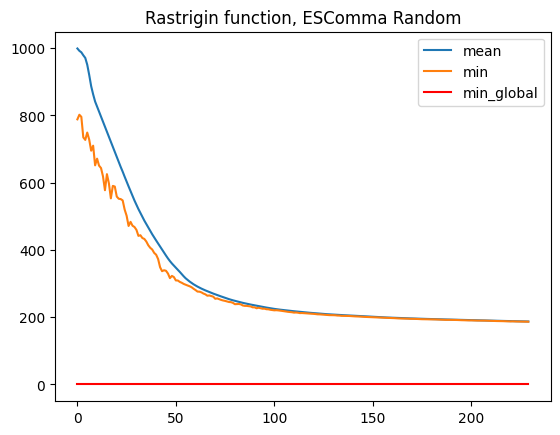

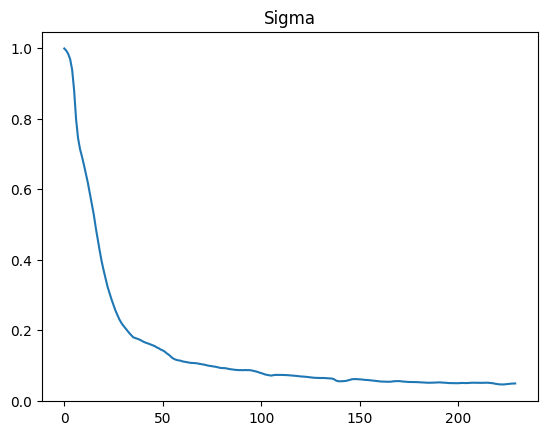

In [61]:
ESCommaRandom(domain, dims, initial_population, offspring_size, Rastrigin, iterations, 'Rastrigin function, ESComma Random', 0)

In [64]:
#benchmark 3 Ackley function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page295.htm
def Ackley(individual):
    d = len(individual)
    return -20*np.exp(-0.2*np.sqrt(np.sum(individual**2)/d)) - np.exp(np.sum(np.cos(2*np.pi*individual))/d) + 20 + np.exp(1)

domain = (-15, 30)
dims = 40
initial_population = 4000
offspring_size = 21000
iterations = 200

100%|██████████| 200/200 [01:57<00:00,  1.70it/s]

Best individual: [-9.85576683e-01 -9.68063839e-01 -1.00359575e+00 -7.05497839e-03
 -9.66410058e-01  7.56952256e-03  9.89482500e-01 -2.73698537e-03
  9.74882758e-01  2.38935601e-02 -4.90717187e+00  3.10488270e-03
  1.00187897e+00 -9.82898537e-01 -9.63405475e-01  5.46807709e-03
 -2.39156609e-03  3.62144520e-04  9.62634137e-01  1.62823994e-02
 -1.16630517e-02  9.80436111e-01 -5.60307490e-03  6.78591268e-03
  5.25398536e-03  9.83022794e-01 -1.95301573e+00  9.93167960e-01
  5.81721119e-04 -9.72742679e-01  8.48478316e-03 -6.94952656e-03
 -9.73012034e-01  9.78024335e-01 -1.21100697e-02  4.93320065e+00
 -7.38782083e-03  3.27399548e-03 -9.85630375e-01 -1.42203121e-02]
Best score: 4.641945883128233


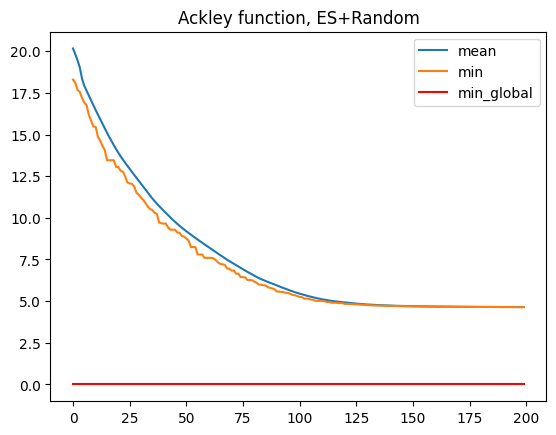

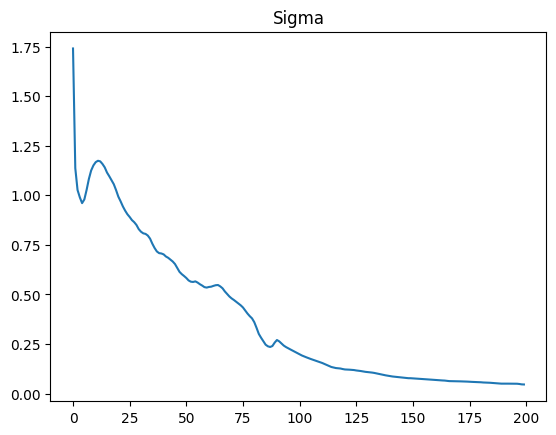

In [65]:
ESPlusRandom(domain, dims, initial_population, offspring_size, Ackley, iterations, 'Ackley function, ES+Random', 0)

100%|██████████| 200/200 [02:06<00:00,  1.58it/s]

Best individual: [-9.71789361e-01 -1.94320874e+00 -9.68951325e-01  2.08536426e-03
 -1.95855577e+00 -9.68147532e-01 -5.51051212e-04  6.91089034e-06
 -5.15022696e-03 -5.61049796e-03 -2.31363678e-03  1.94696965e+00
  3.56853643e-03  2.21256054e-03  1.97741925e+00 -1.20750250e-03
  3.44973929e-03  2.61320501e-03  9.71243453e-01 -5.01080338e-04
 -9.68607404e-01 -2.90215789e+00  2.28047675e-03  9.68566690e-01
  9.68898406e-01 -9.70037279e-01 -1.59280529e-03 -1.94194449e+00
 -1.94528570e+00  9.68730413e-01  9.76052340e-01 -9.73075980e-01
  1.85628237e-03 -3.35972521e-03 -5.68041470e-03 -2.76050379e-03
 -2.42615537e-03  2.68871585e-03  9.73238307e-01 -9.63489160e-01]
Best score: 3.813444772505165


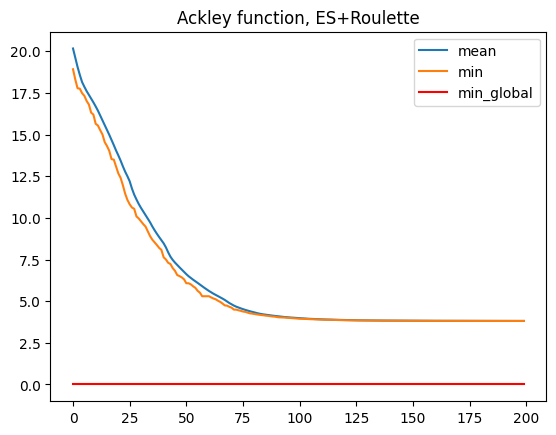

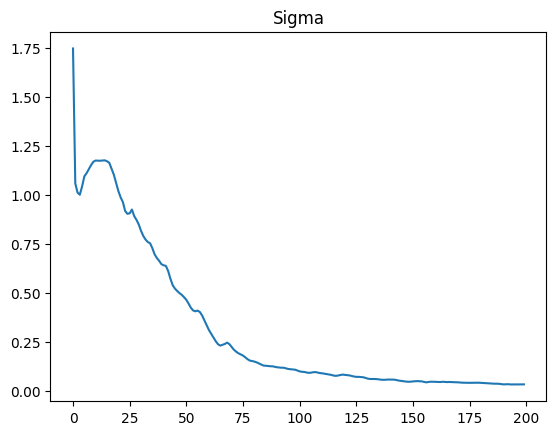

In [66]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, Ackley, iterations, 'Ackley function, ES+Roulette', 0)

100%|██████████| 200/200 [02:54<00:00,  1.15it/s]

Best individual: [-5.08303403e-02 -9.99879136e-01 -2.06131037e-02 -1.93253688e-02
  1.89679861e-02 -4.03572969e-02  1.83588963e+00  1.21818941e-02
 -2.03609770e-02  1.03013331e+00 -9.12067514e-01  6.10290961e-02
 -9.66881488e-01 -9.46114043e-01 -1.45539300e-02  4.36929294e-02
 -9.87975612e-03  8.12368495e-03  6.95713734e-03  1.97420888e-03
 -9.12682430e-01  9.37976314e-01  9.48312888e-01  8.40466067e-04
 -9.45449810e-01  8.50915462e-03  4.68361142e-04  9.21392263e-01
  9.64842475e-01 -1.04398302e+00  3.21530917e-02  9.03866097e-01
  1.31232856e-02 -2.36122312e-02  8.65010089e-03  5.23643924e-03
  9.44220276e-01 -3.20801790e-02  8.58537532e-02 -3.59407685e-02]
Best score: 2.519251677184539


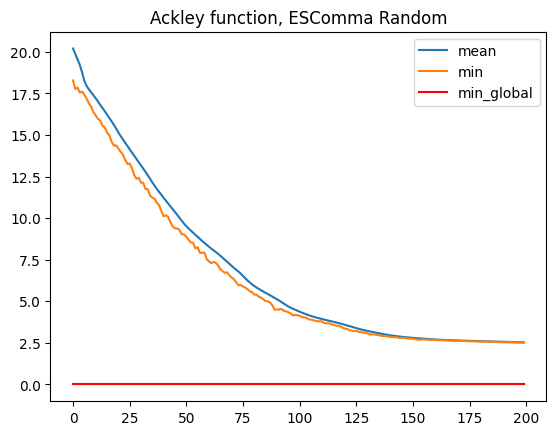

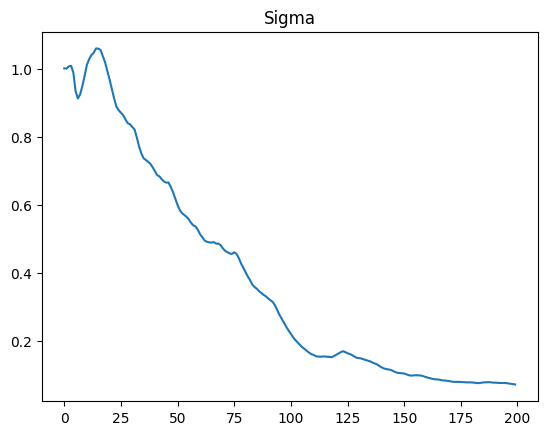

In [67]:
ESCommaRandom(domain, dims, initial_population, offspring_size, Ackley, iterations, 'Ackley function, ESComma Random', 0)

100%|██████████| 200/200 [02:54<00:00,  1.15it/s]

Best individual: [-9.63746815e-01  9.70756294e-01  3.91381061e+00 -1.36289380e-03
 -1.92756666e-03 -1.47314703e-03 -4.65701171e-04 -4.06807706e-03
 -2.33611195e-04  3.92772479e-03 -3.74857680e-04 -8.23983693e-03
  8.23251484e-03 -9.61182680e-01 -6.41939613e-03 -9.62202856e-01
 -9.72653900e-01  1.31770269e-03 -1.02545228e-03 -9.63086581e-01
 -4.77638834e-04 -2.29341895e-03  2.89924503e+00  4.28662584e-04
  1.45073939e-03  1.92458093e-03 -1.18361190e-03  1.32719218e-03
  9.91857039e-03 -9.81746090e-01  3.58772546e-03 -9.63123243e-01
  9.67238974e-01 -7.59595228e-03 -5.21388409e-03 -7.77648081e-03
  9.67791603e-01 -1.30689800e-03  9.64970166e-01 -3.73996879e-03]
Best score: 3.4080275468870522


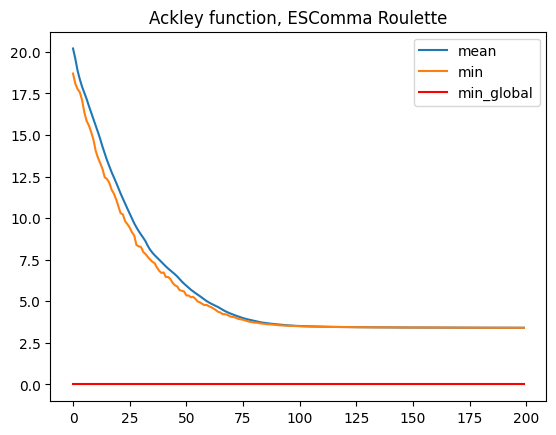

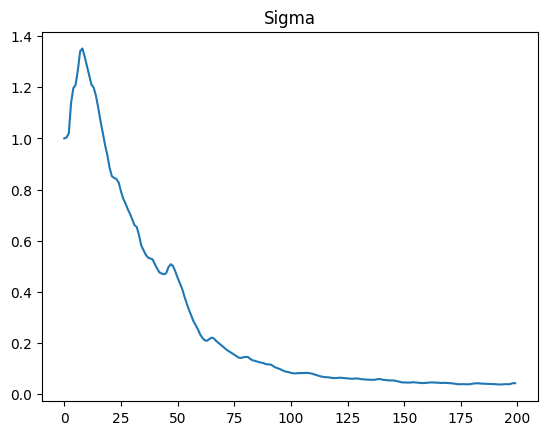

In [68]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, Ackley, iterations, 'Ackley function, ESComma Roulette', 0)

In [69]:
#benchmark 4 Easom function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1361.htm
def Easom(individual):
    return -np.cos(individual[0])*np.cos(individual[1])*np.exp(-((individual[0]-np.pi)**2 + (individual[1]-np.pi)**2))

domain = (-100, 100)
dims = 2
initial_population = 4000
offspring_size = 21000
iterations = 20

100%|██████████| 20/20 [00:13<00:00,  1.50it/s]

Best individual: [3.14159168 3.14159283]
Best score: -0.9999999999985247


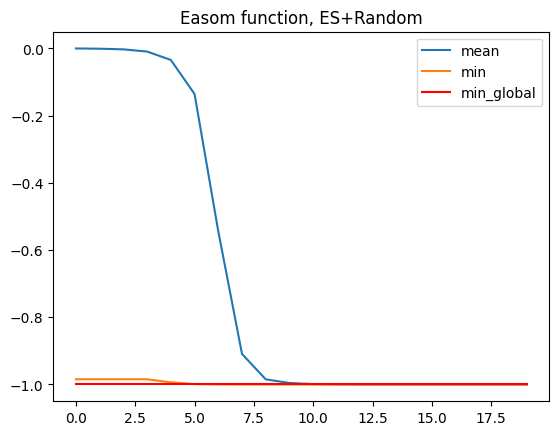

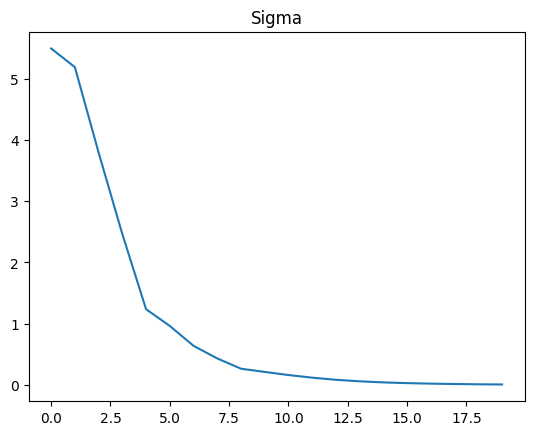

In [70]:
ESPlusRandom(domain, dims, initial_population, offspring_size, Easom, iterations, 'Easom function, ES+Random', -1)

100%|██████████| 20/20 [00:13<00:00,  1.52it/s]

Best individual: [3.14159265 3.14159265]
Best score: -1.0


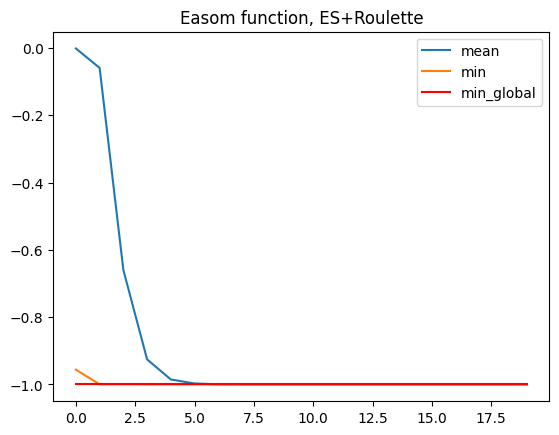

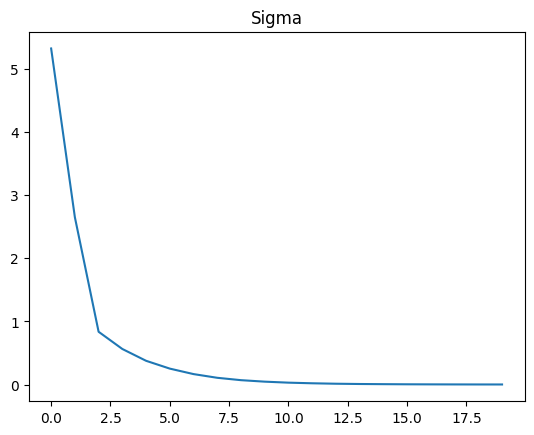

In [71]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, Easom, iterations, 'Easom function, ES+Roulette', -1)

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

Best individual: [3.14159099 3.1415933 ]
Best score: -0.9999999999951977


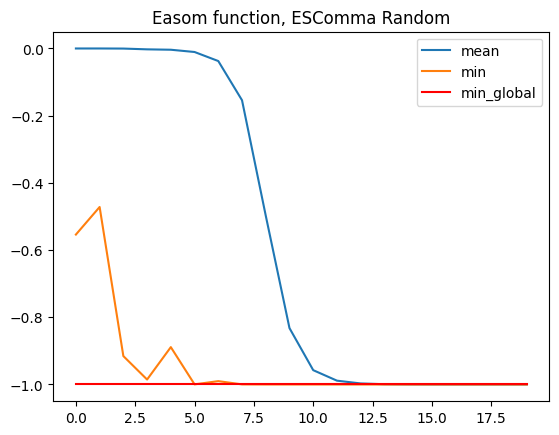

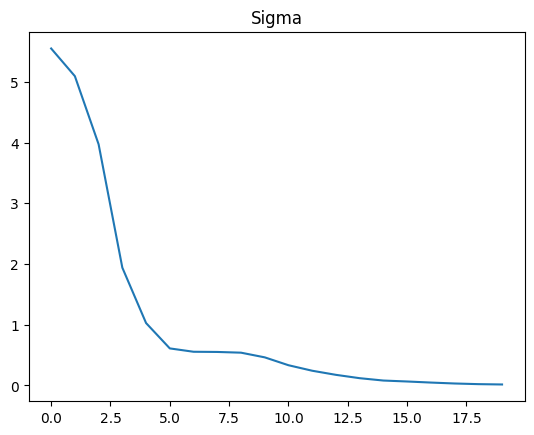

In [72]:
ESCommaRandom(domain, dims, initial_population, offspring_size, Easom, iterations, 'Easom function, ESComma Random', -1)

100%|██████████| 20/20 [00:13<00:00,  1.52it/s]

Best individual: [3.14159265 3.14159266]
Best score: -1.0


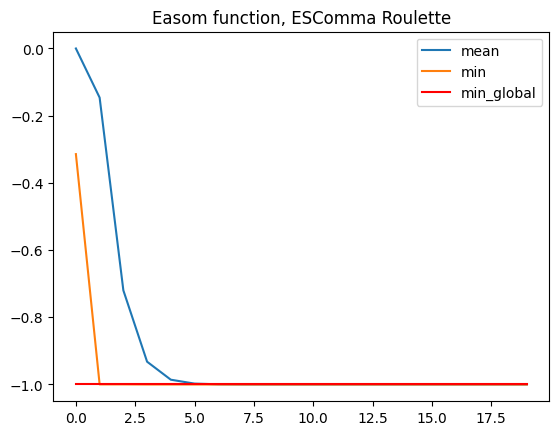

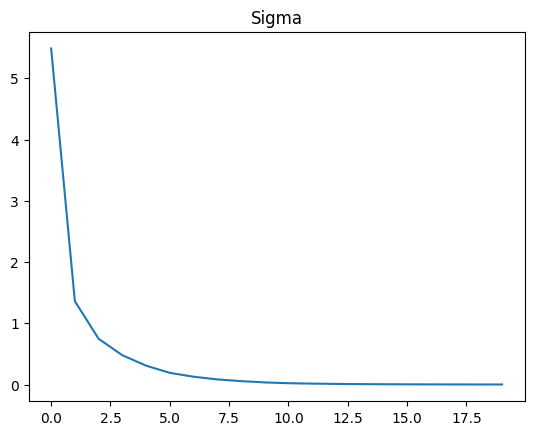

In [73]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, Easom, iterations, 'Easom function, ESComma Roulette', -1)

In [76]:
#benchmark 5 Schwefel function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page2530.htm
def Schwefel(individual):
    d = len(individual)
    value = 418.9829*d
    for i in range(d):
        value -= individual[i] * np.sin(np.sqrt(np.abs(individual[i])))
    return value 

domain = (-500, 500)
dims = 30
initial_population = 4000
offspring_size = 21000
iterations = 400

100%|██████████| 400/400 [12:31<00:00,  1.88s/it]

Best individual: [ 420.87542832  421.06462804   65.35863904  420.74617858  420.87601864
 -302.33329859 -299.74384022  203.64337696  420.85160072  204.0797224
 -302.70461505  421.05944623 -302.34657049 -302.58691888  203.56047098
  204.00518143 -302.77021202  420.89375925 -122.85297192  420.91073879
  420.94647313  421.09407004 -302.55618586  420.74552507  420.98943638
  204.12943358  205.00645967 -302.59750361  204.08629502 -499.99870428]
Best score: 3359.1040040468624


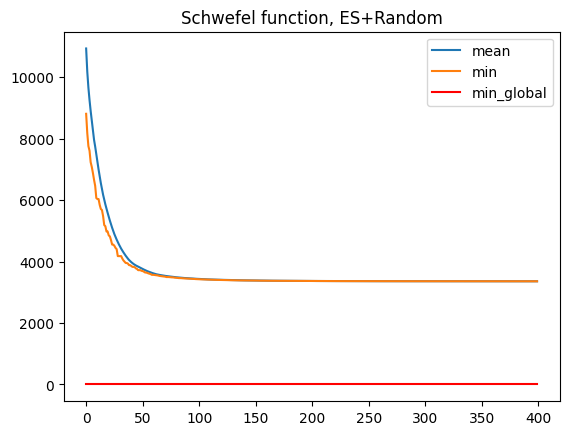

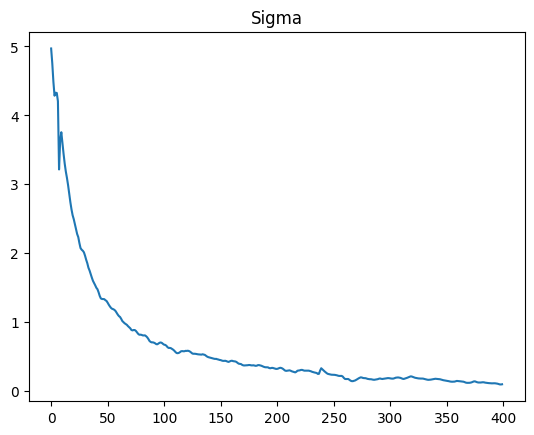

In [77]:
ESPlusRandom(domain, dims, initial_population, offspring_size, Schwefel, iterations, 'Schwefel function, ES+Random', 0)

100%|██████████| 30/30 [00:14<00:00,  2.01it/s]

Best individual: [420.96875277 420.96871893 420.96872628]
Best score: 3.818284983481135e-05


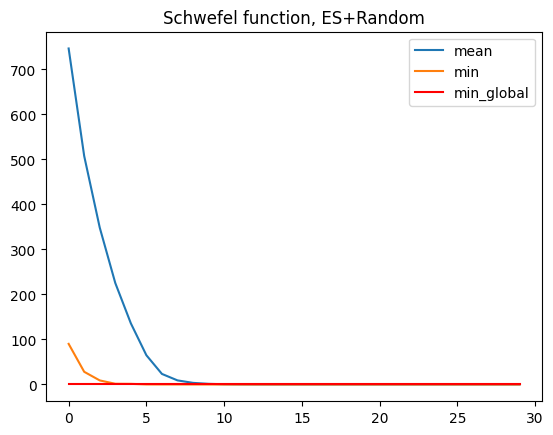

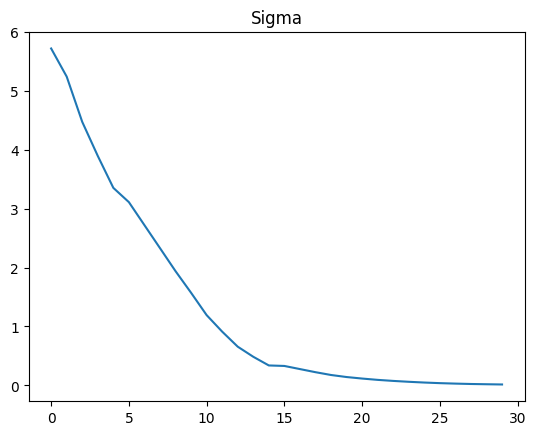

In [81]:
ESPlusRandom(domain, 3, initial_population, offspring_size, Schwefel, 30, 'Schwefel function, ES+Random', 0)

100%|██████████| 30/30 [00:17<00:00,  1.76it/s]

Best individual: [420.9696977  420.97364585 420.9657586  420.96187717 420.96722717]
Best score: 7.415275223365825e-05


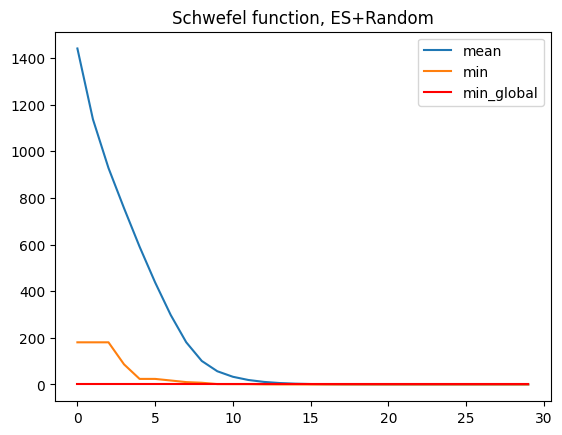

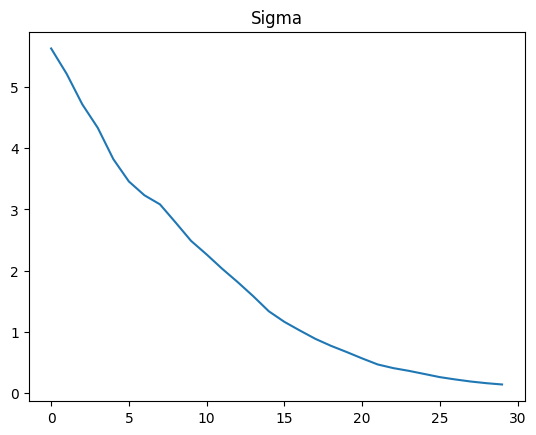

In [83]:
ESPlusRandom(domain, 5, initial_population, offspring_size, Schwefel, 30, 'Schwefel function, ES+Random', 0)

100%|██████████| 400/400 [11:08<00:00,  1.67s/it]

Best individual: [-302.52493243  420.96874811  420.96874453 -302.52493216  420.96874861
 -124.82935651  420.96874531  420.96874507 -302.52493425 -302.52493905
  420.9687475   420.96874799 -302.52493604 -124.82935724 -302.52493634
  420.96874798 -302.5249352   420.96874618 -302.52493609  420.96874611
 -302.5249347  -302.52493536  420.96874699   65.54786386   65.5478665
 -302.52493618  420.96873995  420.96874839  -25.87741956  420.96874589]
Best score: 3000.6312277939696


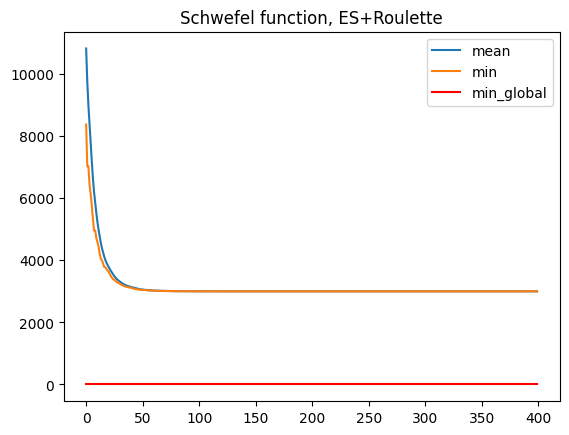

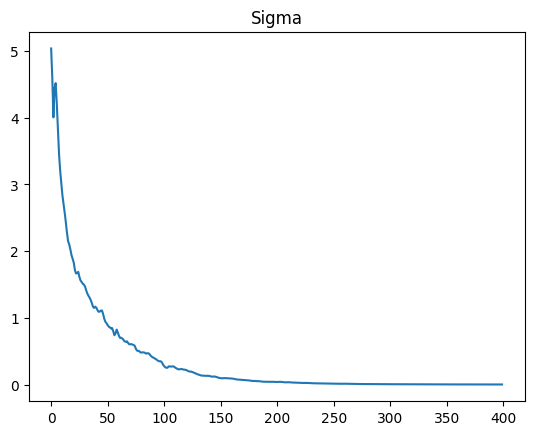

In [78]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, Schwefel, iterations, 'Schwefel function, ES+Roulette', 0)

100%|██████████| 400/400 [15:35<00:00,  2.34s/it]

Best individual: [ 420.91687057 -302.82218251  421.03731954  421.04095229  420.92408321
 -124.87920603  420.97836272  421.00952908  420.9836132  -302.59577574
  421.13630411  420.93801241 -302.47893748  203.91030833  421.03673366
   65.97725682  420.95852562 -499.99999683  203.88168501  420.88739156
 -302.54468328 -302.63575277  419.98825765  419.79862429   65.49428743
  203.74828011  421.0415458   203.65949946 -302.47800786  203.90968299]
Best score: 3041.8724578164292


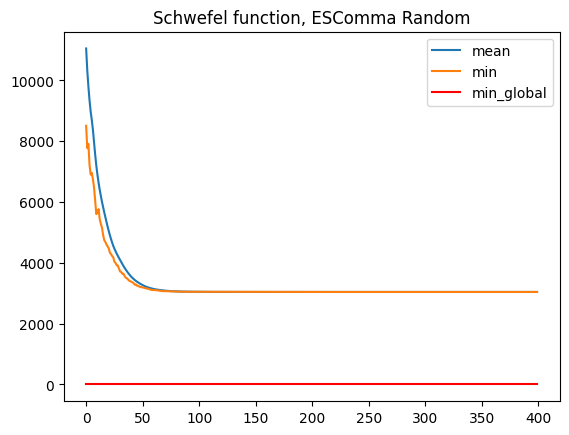

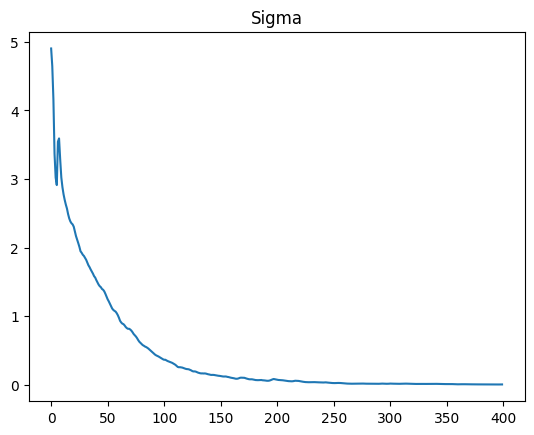

In [84]:
ESCommaRandom(domain, dims, initial_population, offspring_size, Schwefel, iterations, 'Schwefel function, ESComma Random', 0)

100%|██████████| 400/400 [15:02<00:00,  2.26s/it]

Best individual: [-302.52493367  420.96874861 -302.52493563    5.23919802 -302.52493219
  420.96874529  -25.87741939  203.81425543  420.96874826  420.96874708
 -302.52493215 -302.52493327  203.81425178 -124.82935447 -302.5249354
   65.54786568  203.81425602 -302.52493499  420.96874729 -302.52493592
  420.96874584  420.96874511 -302.52493572  420.96874744  420.96874536
  203.81425258 -302.52493507 -302.52493615 -302.52493423 -124.82935577]
Best score: 4047.317920296967


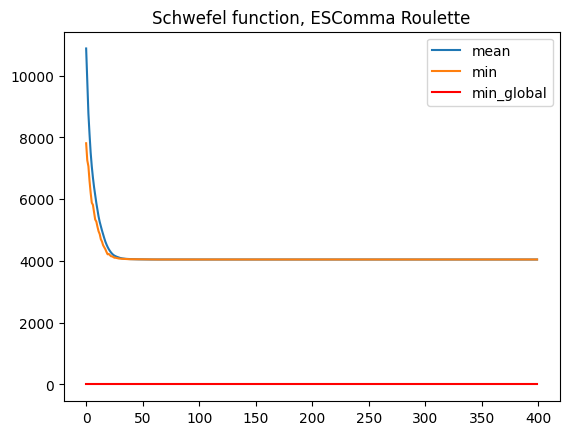

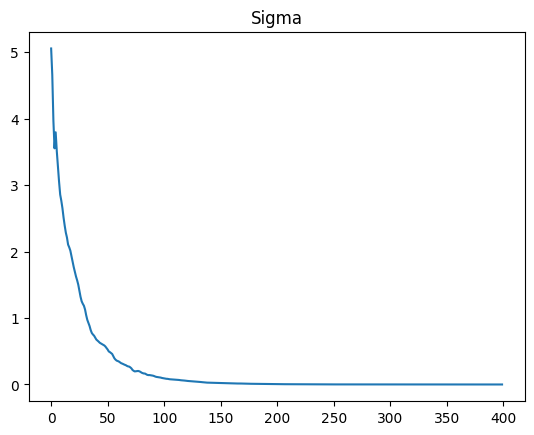

In [85]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, Schwefel, iterations, 'Schwefel function, ESComma Roulette', 0)